In [1]:
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import sys
import os
import random
from importlib import reload
from tqdm import tqdm
import copy

# Generate Data

In [2]:
# make data - using uniform dist and ranges
def generate_data(data_ranges, length, epsilon=0.0):
    # get max dims
    dims_x = [np.inf, -np.inf]
    dims_y = [np.inf, -np.inf]
    for clus in data_ranges:
        if(clus[0][0] < dims_x[0]):
            dims_x[0] = clus[0][0]
        if(clus[0][1] > dims_x[1]):
            dims_x[1] = clus[0][1]
        if(clus[1][0] < dims_y[0]):
            dims_y[0] = clus[1][0]
        if(clus[1][1] > dims_y[1]):
            dims_y[1] = clus[1][1]

    # generate
    data = np.zeros((1,2))
    labels = []
    for i,clus in enumerate(data_ranges):
        for j in range(length):
            if(np.random.rand() >= epsilon):
                data = np.append(data, [[
                    np.random.uniform(clus[0][0], clus[0][1]),
                    np.random.uniform(clus[1][0], clus[1][1]),
                ]], axis=0)
                labels.append(i)
            else:
                data = np.append(data, [[
                    np.random.uniform(dims_x[0], dims_x[1]),
                    np.random.uniform(dims_y[0], dims_y[1])
                ]], axis=0)
                labels.append(9)

    data = data[1:]

    return data, labels

In [3]:
# Split data for display - plt
def split_data(data, labels):
    data_sep = []
    uniq_labels = list(set(sorted(labels)))
    for cl in uniq_labels:
        data_class = np.zeros((1,2))
        for i,lab in enumerate(labels):
            if(cl == lab):
                data_class = np.append(data_class, [data[i]], axis=0)
        data_class = data_class[1:]
        data_sep.append(data_class)
    return data_sep, uniq_labels

In [4]:
# graph separated data w/ plt
def plt_graph_sep_data(data):
    fig, ax = plt.subplots()
    for cl in data:
        ax.scatter(cl[:,0], cl[:,1])
    plt.show()

In [5]:
def expand_labels(labels):
    uniqs = list(set(sorted(labels)))
    expanded = []
    for lab in labels:
        new_exp = [0] * len(uniqs)
        new_exp[uniqs.index(lab)] = 1
        expanded.append(new_exp)
    return expanded

In [6]:
data_ranges = [
    [ [-14.0, -2.0], [6.0, 16.0] ],
    [ [2.0, 15.0],   [-8.0, 6.0] ],
    [ [-12.0, -4.0], [-14.0, -6.0] ]
]
data, labels = generate_data(data_ranges, length=500)

# Train RBN (Gradient Descent)

In [7]:
labels_expand = expand_labels(labels)

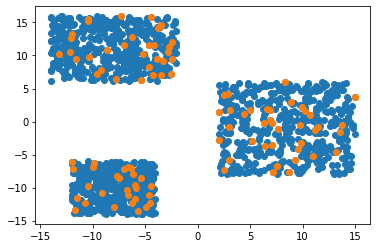

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [14:47<00:00,  1.77s/it]

Completed Training: 500 epochs
Best Error: 1.7504120661536725e-05


In [37]:
import rbn_gd
reload(rbn_gd)

rbnetwork = rbn_gd.RBN(k=100, outputs=1)
error, centers = rbnetwork.train(
    data, 
    labels, 
    alpha=1e-3, 
    epochs=500, 
    batch_size=200, 
    dw_target=.001,
    save_config=True
)

# rbnetwork = rbn.RBN(k=50, outputs=3)
# error = rbnetwork.train(data, labels_expand, alpha=1e-1, epochs=500, batch_size=100, error_target=1e-2)

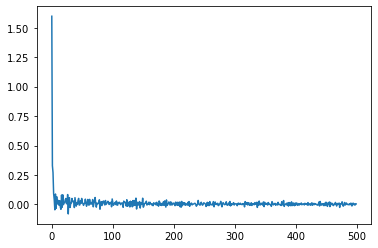

In [38]:
fig, ax = plt.subplots()
ax.plot(error)

# Test RBN (resub)

In [39]:
def classify(pred, labels):
    uniqs = list(set(sorted(labels)))
    min_d = np.inf
    min_i = 0
    for i,l in enumerate(uniqs):
        dis = abs(pred - l)
        if(dis < min_d):
            min_d = dis
            min_i = i
    return uniqs[min_i]

In [40]:
def test_model(model, data, labels, centers):
    # new_data = np.array([*data[0:2], *data[100:102], *data[200:202]])
    # print(new_data.shape)
    truepos = 0
    preds = []
    for d, l in zip(data, labels):
        pred = model.forward(d)
        pred = classify(pred,labels)
        preds.append(pred)
        if(pred == l):
            truepos += 1

    accuracy = truepos / len(data)
    print('Accuracy:', round(accuracy,2))
    
    data_sep, uniq_labels = split_data(data, preds)
    data_sep.append(centers)
    plt_graph_sep_data(data_sep)
    
    return preds

Accuracy: 0.99


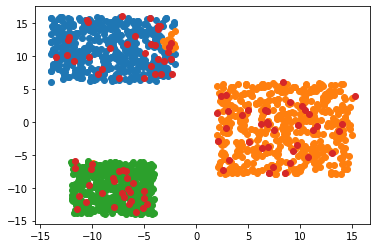

In [41]:
preds = test_model(rbnetwork, data, labels, centers)

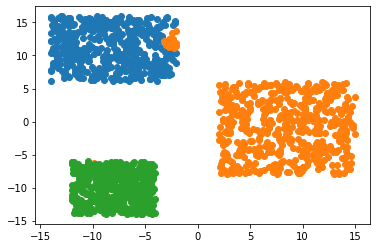

In [42]:
data_sep, uniq_labels = split_data(data, preds)
plt_graph_sep_data(data_sep)

# Grid search to map space

In [45]:
def grid_search(data, model, step=(.5,.5)):
    # generate data
    x = np.arange(min(data[:,0]), max(data[:,0]), step[0])
    y = np.arange(min(data[:,1]), max(data[:,1]), step[1])

    # grid_xy = np.zeros((len(x), len(x)))
    xy_data  = []
    xy_preds = []
    z_preds  = np.zeros((len(x), len(y)))
    z_data   = np.zeros((len(x), len(y)))
    for i in tqdm(range(len(x))):
        for j in range(len(y)):
            pred = model.forward([x[i], y[j]])
            z    = copy.deepcopy(pred)
            pred = classify(pred,labels)
            xy_data.append([x[i], y[j]])
            xy_preds.append(pred)
            z_preds[i,j] = pred
            z_data[i,j]  = z
    
    # predict on grid
    xy_sep, xy_uniq_labels = split_data(xy_data, xy_preds)
    plt_graph_sep_data(xy_sep)
    
    # Plot surface - raw predictions
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    xy_data, xy_preds, z_data = np.array(xy_data), np.array(xy_preds), np.array(z_data)
    Y, X = np.meshgrid(y, x)
    ax.plot_surface(X, Y, z_data, cmap=cm.coolwarm)
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.42it/s]


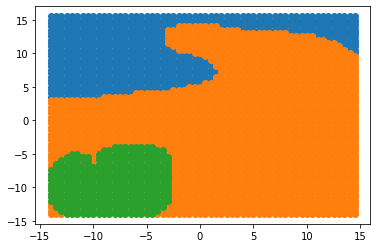

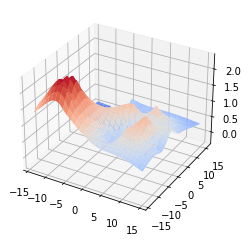

In [46]:
grid_search(data, rbnetwork, step=(.5,.5))

In [49]:
rbnetwork.centers

array([[ 10.85189526,   1.17722616],
       [ 14.00111884,  -0.26669606],
       [  6.20081686,  -0.38564779],
       [ -2.36288681,   7.35629032],
       [-11.61280695,  -6.9912418 ],
       [ -6.02768033,  -9.27883442],
       [ -7.86048411, -12.92149369],
       [ 13.10541979,  -4.64855256],
       [  6.79635669,   0.0211369 ],
       [ 11.64034602,  -0.63577031],
       [ -9.01080363,   8.08032138],
       [  2.07529339,  -2.83750782],
       [  2.90437088,  -0.86486546],
       [ -6.39976019, -10.65988458],
       [ 13.71802663,  -1.44879465],
       [ -5.78828173, -13.68300023],
       [  6.94848831,  -3.772483  ],
       [-12.42388798,  10.23240072],
       [ -6.656873  ,  11.902996  ],
       [  3.02101497,   1.64385824],
       [  9.67384363,  -3.46480884],
       [ -4.33906351,  11.8776336 ],
       [ -4.70527319, -12.55044352],
       [ 10.42983049,   1.80380642],
       [ -7.10180154, -10.83351201],
       [ -4.89278287,  10.55097833],
       [  3.15068755,  -5.76903176],
 